Fecha solicitada : 2017-02-05 12:00:00
Fecha usada ERA5 : 2017-02-05 12:00:00


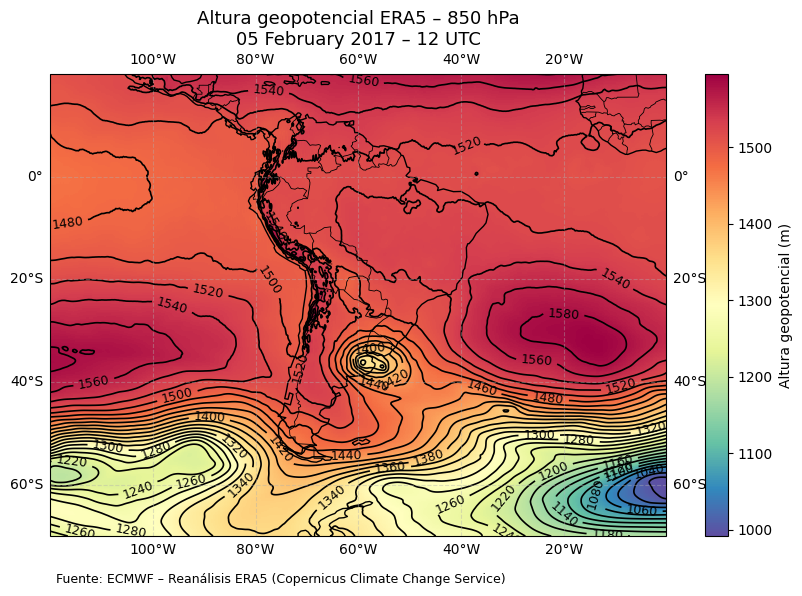

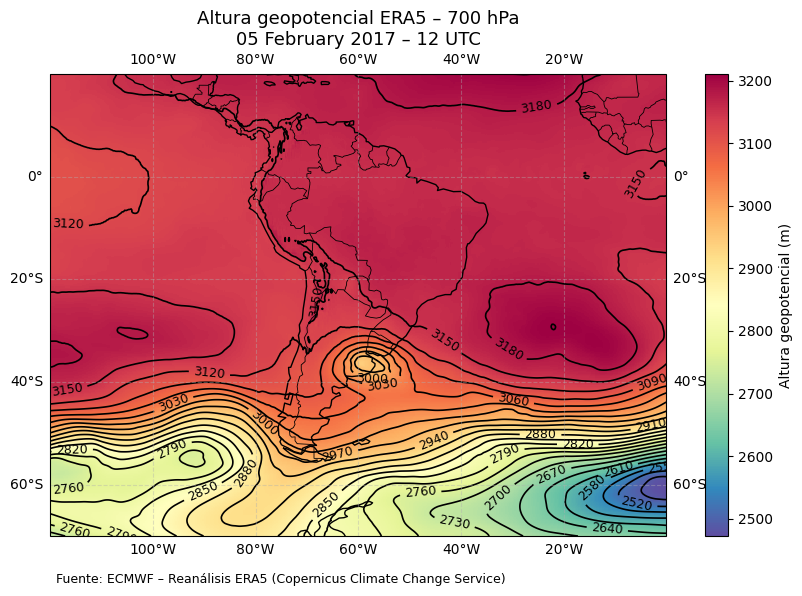

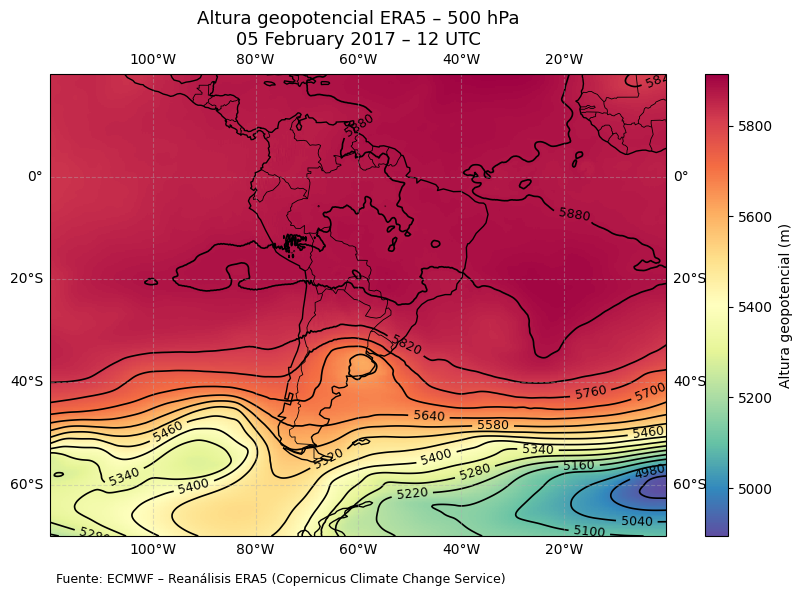

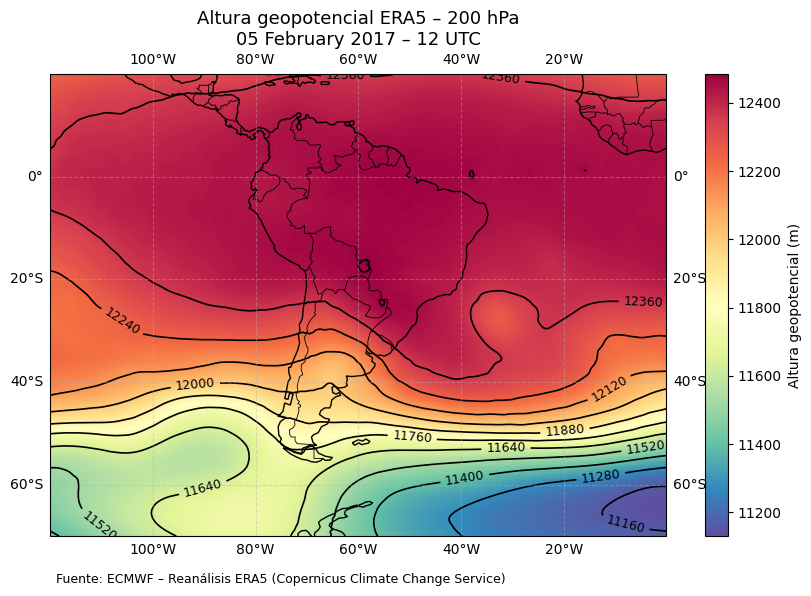

In [26]:
# ------------------------------------------
# MAPAS DE ALTURA GEOPOTENCIAL - ERA5
# FECHA INGRESADA POR EL USUARIO
# ------------------------------------------

import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import pandas as pd

# ------------------------------------------
# ABRIR ARCHIVO
# ------------------------------------------
ruta = r"C:\Users\ANALY AVALOS\Downloads\feb_mar58.nc"
ds = xr.open_dataset(ruta)

# ------------------------------------------
# CORREGIR LONGITUDES (0–360 → -180–180)
# ------------------------------------------
if ds.longitude.max() > 180:
    ds = ds.assign_coords(
        longitude=((ds.longitude + 180) % 360) - 180
    ).sortby("longitude")

# ------------------------------------------
# PEDIR FECHA AL USUARIO
# ------------------------------------------
fecha_input = input("Ingresa la fecha (YYYY-MM-DD HH, en UTC): ")
fecha_usuario = pd.to_datetime(fecha_input)

# Seleccionar el tiempo más cercano disponible
tiempo_real = ds.valid_time.sel(
    valid_time=fecha_usuario,
    method="nearest"
)

print(f"Fecha solicitada : {fecha_usuario}")
print(f"Fecha usada ERA5 : {pd.to_datetime(tiempo_real.values)}")

# ------------------------------------------
# NIVELES A EVALUAR
# ------------------------------------------
niveles = [850, 700, 500, 200]

# Intervalos de isoípsas (m)
intervalos = {
    850: 20,
    700: 30,
    500: 60,
    200: 120
}

# ------------------------------------------
# LOOP POR NIVEL
# ------------------------------------------
for nivel in niveles:

    # Altura geopotencial en metros
    gph = (
        ds["z"]
        .sel(pressure_level=nivel)
        .sel(valid_time=tiempo_real)
        / 9.80665
    )

    # Recorte espacial
    gph = gph.sel(
        latitude=slice(20, -70),
        longitude=slice(-120, 0)
    )

    # Asegurar matriz 2D
    data = gph.squeeze().values
    lons = gph.longitude.values
    lats = gph.latitude.values
    LON, LAT = np.meshgrid(lons, lats)

    # ------------------------------------------
    # MAPA
    # ------------------------------------------
    fig = plt.figure(figsize=(10, 6))
    ax = plt.axes(projection=ccrs.PlateCarree())

    pcm = ax.pcolormesh(
        LON, LAT, data,
        cmap="Spectral_r",
        shading="nearest",
        transform=ccrs.PlateCarree()
    )

    plt.colorbar(pcm, ax=ax, label="Altura geopotencial (m)")

    # Isoípsas
    step = intervalos[nivel]
    levels = np.arange(
        np.floor(data.min() / step) * step,
        np.ceil(data.max() / step) * step + step,
        step
    )

    cs = ax.contour(
        LON, LAT, data,
        levels=levels,
        colors="black",
        linewidths=1.2,
        transform=ccrs.PlateCarree()
    )
    ax.clabel(cs, fmt="%d", fontsize=9)

    # Detalles cartográficos
    ax.coastlines()
    ax.add_feature(cfeature.BORDERS, linewidth=0.6)
    ax.add_feature(cfeature.STATES, linewidth=0.3)
    ax.gridlines(draw_labels=True, linestyle="--", alpha=0.4)

    ax.set_extent([-120, 0, -70, 20], crs=ccrs.PlateCarree())

    # ------------------------------------------
    # TÍTULO
    # ------------------------------------------
    ax.set_title(
        f"Altura geopotencial ERA5 – {nivel} hPa\n"
        f"{pd.to_datetime(tiempo_real.values).strftime('%d %B %Y – %H UTC')}",
        fontsize=13
    )

    # ------------------------------------------
    # FUENTE
    # ------------------------------------------
    ax.text(
        0.01, -0.08,
        "Fuente: ECMWF – Reanálisis ERA5 (Copernicus Climate Change Service)",
        transform=ax.transAxes,
        fontsize=9,
        ha="left",
        va="top"
    )

    plt.show()
